In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('SBIN.NS.csv')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
df.iloc[:,1:2]

,Open
0,18.691147
1,18.894005
2,18.327892
3,17.502312
4,17.738192
...,...
6768,599.099976
6769,601.000000
6770,602.099976
6771,598.150024


In [5]:
from tensorflow.keras.models import load_model

2022-11-30 22:21:03.664917: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 22:21:05.402557: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/voldemort/anaconda3/lib/
2022-11-30 22:21:05.402702: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/voldemort/anaconda3/lib/
2022-11-30 22:21:05.402718: W tensorflow/compiler/tf2tensorrt/util

In [6]:
model = load_model('sbi_model.h5')

2022-11-30 22:21:07.339432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-30 22:21:07.387023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-30 22:21:07.387109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-30 22:21:07.388196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6773 entries, 0 to 6772
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6773 non-null   object 
 1   Open       6764 non-null   float64
 2   High       6764 non-null   float64
 3   Low        6764 non-null   float64
 4   Close      6764 non-null   float64
 5   Adj Close  6764 non-null   float64
 6   Volume     6764 non-null   float64
dtypes: float64(6), object(1)
memory usage: 370.5+ KB


In [8]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6768,2022-11-17,599.099976,602.750000,596.150024,599.049988,599.049988,8167131.0
6769,2022-11-18,601.000000,605.750000,597.150024,602.700012,602.700012,12933675.0
6770,2022-11-21,602.099976,602.099976,595.349976,598.099976,598.099976,7412419.0
6771,2022-11-22,598.150024,600.700012,596.150024,599.099976,599.099976,8048595.0
6772,2022-11-23,601.549988,609.599976,601.000000,607.650024,607.650024,12435924.0


<AxesSubplot:xlabel='Date', ylabel='Open'>

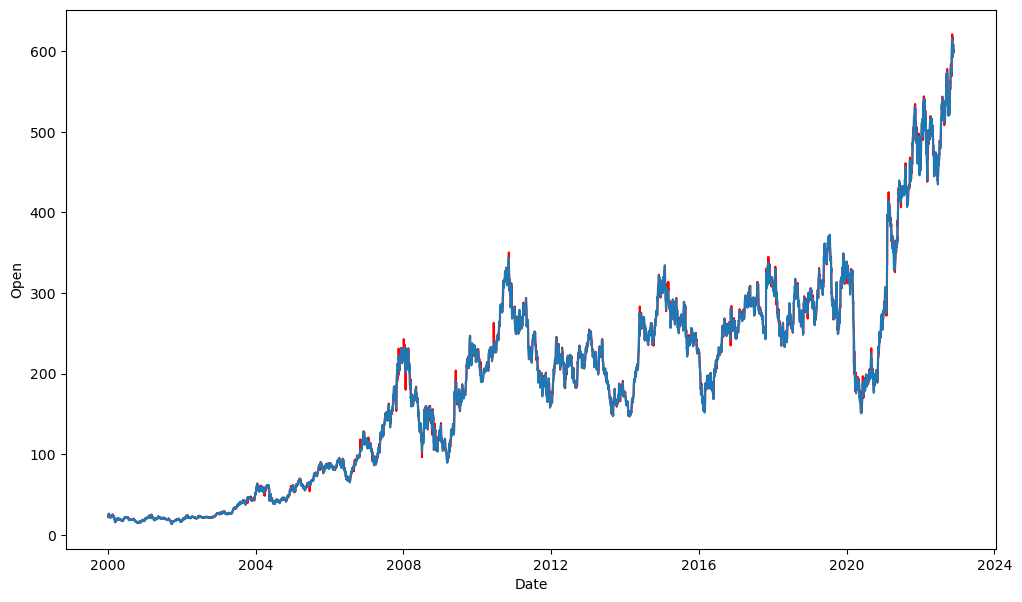

In [9]:
import datetime
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(12,7))
sns.lineplot(x='Date', y='Open',
             color='red',
             data=df[df['Date'] > pd.to_datetime(datetime.date(2000,1,1))])
sns.lineplot(x='Date', y='Close', 
             data=df[df['Date'] > pd.to_datetime(datetime.date(2000,1,1))])

## Prediction with predicted value tests

In [114]:
df = df.dropna()

In [115]:
train_ind = int(len(df)*0.8)
df_train = df[:train_ind]
df_test = df[train_ind:]

In [116]:
df_test

,Date,Open,High,Low,Close,Adj Close,Volume
5420,2017-06-05,288.049988,289.750000,286.750000,287.250000,280.248627,7917410.0
5421,2017-06-06,292.000000,292.950012,286.600006,287.299988,280.297394,12346121.0
5422,2017-06-07,288.200012,291.500000,287.200012,290.549988,283.468170,10864355.0
5423,2017-06-08,292.000000,292.000000,287.750000,288.600006,281.565735,8370299.0
5424,2017-06-09,288.299988,289.399994,285.799988,288.549988,281.516907,10804887.0
...,...,...,...,...,...,...,...
6768,2022-11-17,599.099976,602.750000,596.150024,599.049988,599.049988,8167131.0
6769,2022-11-18,601.000000,605.750000,597.150024,602.700012,602.700012,12933675.0
6770,2022-11-21,602.099976,602.099976,595.349976,598.099976,598.099976,7412419.0
6771,2022-11-22,598.150024,600.700012,596.150024,599.099976,599.099976,8048595.0


In [117]:
timestep = 60

In [118]:
r_data = df_test.iloc[:60, 1:2].values

In [119]:
len(r_data)

60

In [120]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [121]:
r_data = scaler.fit_transform(r_data)

In [122]:
r_data.shape

(60, 1)

In [123]:
r_data = np.reshape(r_data, (1, timestep, 1))

In [162]:
r_data.shape

(1, 60, 1)

In [125]:
t_data.reshape(1,-1)

array([[0.38214257, 0.47619048, 0.38571457, 0.47619048, 0.38809495,
        0.35119048, 0.31904748, 0.33095224, 0.282143  , 0.30238124,
        0.34761919, 0.37142871, 0.38690476, 0.45833333, 0.54166667,
        0.41071429, 0.13333348, 0.1226189 , 0.        , 0.05000014,
        0.07142857, 0.04523795, 0.07261876, 0.20476205, 0.28809538,
        0.36904762, 0.30238124, 0.40238081, 0.39999971, 0.49523781,
        0.47261919, 0.46428571, 0.5       , 0.45357114, 0.44761876,
        0.57142857, 0.57738095, 0.5952381 , 0.5952381 , 0.65238081,
        1.        , 0.9047619 , 0.83333333, 0.67380924, 0.80476162,
        0.92857143, 0.73214286, 0.69523838, 0.53571429, 0.22500029,
        0.16785686, 0.2809521 , 0.14285714, 0.16666667, 0.0952381 ,
        0.06547619, 0.18333362, 0.24047633, 0.15357171, 0.14285714]])

In [159]:
o=[x[0] for x in t_data[0]]
o.append(p1[0].tolist()[0])
o = np.array(o[1:]).reshape(1,60,1)
o

array([[[4.76190476e-01],
        [3.85714571e-01],
        [4.76190476e-01],
        [3.88094952e-01],
        [3.51190476e-01],
        [3.19047476e-01],
        [3.30952238e-01],
        [2.82143000e-01],
        [3.02381238e-01],
        [3.47619190e-01],
        [3.71428714e-01],
        [3.86904762e-01],
        [4.58333333e-01],
        [5.41666667e-01],
        [4.10714286e-01],
        [1.33333476e-01],
        [1.22618905e-01],
        [0.00000000e+00],
        [5.00001429e-02],
        [7.14285714e-02],
        [4.52379524e-02],
        [7.26187619e-02],
        [2.04762048e-01],
        [2.88095381e-01],
        [3.69047619e-01],
        [3.02381238e-01],
        [4.02380810e-01],
        [3.99999714e-01],
        [4.95237810e-01],
        [4.72619190e-01],
        [4.64285714e-01],
        [5.00000000e-01],
        [4.53571143e-01],
        [4.47618762e-01],
        [5.71428571e-01],
        [5.77380952e-01],
        [5.95238095e-01],
        [5.95238095e-01],
        [6.5

In [127]:
p1 = model.predict(r_data)

1/1 [==============================] - 0s 50ms/step


In [128]:
p1 = scaler.inverse_transform(p1)

In [144]:
p1[0].tolist()[0]

279.929443359375

In [130]:
df_test.iloc[61]

Date         2017-09-01 00:00:00
Open                  277.649994
High                  280.399994
Low                   276.600006
Close                 277.850006
Adj Close             271.077759
Volume                 8255209.0
Name: 5481, dtype: object

In [186]:
# data_till_friday should be scaled and in shape (1,60,1)
def weekly_prediction(model, data_till_friday,scaler):
    lst_output=[]
    lst_input = [x[0] for x in data_till_friday[0]]
    i=0
    while i<30:
        p = model.predict(data_till_friday)
        x = lst_input[1:]
        x.append(p[0].tolist()[0])
        print(x)
        lst_output.append(p[0].tolist()[0])
        p = scaler.inverse_transform(p)
        print(f'prediction {p}')
        data_till_friday = np.array(x).reshape(1,60,1)
        i+=1
    return lst_output
        

In [187]:
res = weekly_prediction(model, r_data, scaler)

1/1 [==============================] - 0s 45ms/step
[0.4761904761904754, 0.38571457142857124, 0.4761904761904754, 0.3880949523809516, 0.3511904761904754, 0.3190474761904758, 0.33095223809523766, 0.2821429999999996, 0.3023812380952382, 0.3476191904761903, 0.371428714285714, 0.38690476190476186, 0.45833333333333304, 0.5416666666666661, 0.4107142857142856, 0.13333347619047586, 0.12261890476190374, 0.0, 0.050000142857142826, 0.07142857142857117, 0.04523795238095207, 0.07261876190476091, 0.20476204761904704, 0.28809538095238096, 0.3690476190476186, 0.3023812380952382, 0.40238080952380884, 0.39999971428571346, 0.49523780952380836, 0.4726191904761903, 0.4642857142857135, 0.4999999999999991, 0.4535711428571423, 0.4476187619047609, 0.5714285714285712, 0.5773809523809517, 0.5952380952380949, 0.5952380952380949, 0.6523808095238088, 0.9999999999999991, 0.9047619047619042, 0.833333333333333, 0.6738092380952372, 0.8047616190476186, 0.9285714285714279, 0.7321428571428568, 0.6952383809523806, 0.535714

1/1 [==============================] - 0s 52ms/step
[0.4761904761904754, 0.38571457142857124, 0.4761904761904754, 0.3880949523809516, 0.3511904761904754, 0.3190474761904758, 0.33095223809523766, 0.2821429999999996, 0.3023812380952382, 0.3476191904761903, 0.371428714285714, 0.38690476190476186, 0.45833333333333304, 0.5416666666666661, 0.4107142857142856, 0.13333347619047586, 0.12261890476190374, 0.0, 0.050000142857142826, 0.07142857142857117, 0.04523795238095207, 0.07261876190476091, 0.20476204761904704, 0.28809538095238096, 0.3690476190476186, 0.3023812380952382, 0.40238080952380884, 0.39999971428571346, 0.49523780952380836, 0.4726191904761903, 0.4642857142857135, 0.4999999999999991, 0.4535711428571423, 0.4476187619047609, 0.5714285714285712, 0.5773809523809517, 0.5952380952380949, 0.5952380952380949, 0.6523808095238088, 0.9999999999999991, 0.9047619047619042, 0.833333333333333, 0.6738092380952372, 0.8047616190476186, 0.9285714285714279, 0.7321428571428568, 0.6952383809523806, 0.535714

1/1 [==============================] - 0s 40ms/step
[0.4761904761904754, 0.38571457142857124, 0.4761904761904754, 0.3880949523809516, 0.3511904761904754, 0.3190474761904758, 0.33095223809523766, 0.2821429999999996, 0.3023812380952382, 0.3476191904761903, 0.371428714285714, 0.38690476190476186, 0.45833333333333304, 0.5416666666666661, 0.4107142857142856, 0.13333347619047586, 0.12261890476190374, 0.0, 0.050000142857142826, 0.07142857142857117, 0.04523795238095207, 0.07261876190476091, 0.20476204761904704, 0.28809538095238096, 0.3690476190476186, 0.3023812380952382, 0.40238080952380884, 0.39999971428571346, 0.49523780952380836, 0.4726191904761903, 0.4642857142857135, 0.4999999999999991, 0.4535711428571423, 0.4476187619047609, 0.5714285714285712, 0.5773809523809517, 0.5952380952380949, 0.5952380952380949, 0.6523808095238088, 0.9999999999999991, 0.9047619047619042, 0.833333333333333, 0.6738092380952372, 0.8047616190476186, 0.9285714285714279, 0.7321428571428568, 0.6952383809523806, 0.535714

1/1 [==============================] - 0s 69ms/step
[0.4761904761904754, 0.38571457142857124, 0.4761904761904754, 0.3880949523809516, 0.3511904761904754, 0.3190474761904758, 0.33095223809523766, 0.2821429999999996, 0.3023812380952382, 0.3476191904761903, 0.371428714285714, 0.38690476190476186, 0.45833333333333304, 0.5416666666666661, 0.4107142857142856, 0.13333347619047586, 0.12261890476190374, 0.0, 0.050000142857142826, 0.07142857142857117, 0.04523795238095207, 0.07261876190476091, 0.20476204761904704, 0.28809538095238096, 0.3690476190476186, 0.3023812380952382, 0.40238080952380884, 0.39999971428571346, 0.49523780952380836, 0.4726191904761903, 0.4642857142857135, 0.4999999999999991, 0.4535711428571423, 0.4476187619047609, 0.5714285714285712, 0.5773809523809517, 0.5952380952380949, 0.5952380952380949, 0.6523808095238088, 0.9999999999999991, 0.9047619047619042, 0.833333333333333, 0.6738092380952372, 0.8047616190476186, 0.9285714285714279, 0.7321428571428568, 0.6952383809523806, 0.535714

1/1 [==============================] - 0s 56ms/step
[0.4761904761904754, 0.38571457142857124, 0.4761904761904754, 0.3880949523809516, 0.3511904761904754, 0.3190474761904758, 0.33095223809523766, 0.2821429999999996, 0.3023812380952382, 0.3476191904761903, 0.371428714285714, 0.38690476190476186, 0.45833333333333304, 0.5416666666666661, 0.4107142857142856, 0.13333347619047586, 0.12261890476190374, 0.0, 0.050000142857142826, 0.07142857142857117, 0.04523795238095207, 0.07261876190476091, 0.20476204761904704, 0.28809538095238096, 0.3690476190476186, 0.3023812380952382, 0.40238080952380884, 0.39999971428571346, 0.49523780952380836, 0.4726191904761903, 0.4642857142857135, 0.4999999999999991, 0.4535711428571423, 0.4476187619047609, 0.5714285714285712, 0.5773809523809517, 0.5952380952380949, 0.5952380952380949, 0.6523808095238088, 0.9999999999999991, 0.9047619047619042, 0.833333333333333, 0.6738092380952372, 0.8047616190476186, 0.9285714285714279, 0.7321428571428568, 0.6952383809523806, 0.535714

In [188]:
res_d = pd.DataFrame(res)

<AxesSubplot:>

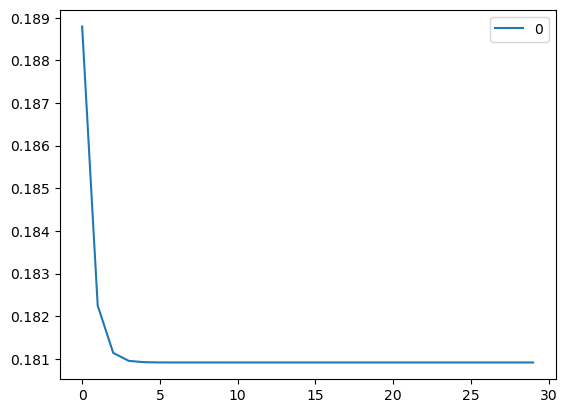

In [189]:
res_d.plot()

In [185]:
res_d

,0
0,0.188796
1,0.182248
2,0.181137
3,0.180950
4,0.180919
